<a href="https://colab.research.google.com/github/souhirbenamor/EPF/blob/main/STAR_model_with_ridge_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import datetime as dt
import pandas as pd
import importlib
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import datetime as dt
import pandas as pd
import importlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
import matplotlib.gridspec as gridspec
%matplotlib inline
import statsmodels.api as sm
import scipy.stats as ss
from scipy.optimize import minimize
from IPython import display
from scipy.linalg import inv
#import functions.Kalman_filter as KF

In [6]:
data = pd.read_excel('/content/MEF-DATA.xlsx')
data.drop(data.loc[data['Date'].duplicated()].index, inplace = True)
#df['datetime'] = pd.to_datetime(df['Date'])

# df = df.sort_values(df['datetime'], ascending=[True])

data.set_index(data['Date'], inplace = True)
data.drop(columns = ['Date'], inplace = True)
data.tail()

,Emission,Generation without Renewbles,Electricity price
Date,,,
2019-12-31 18:59:59.982,9108.529801,39770.082481,41.866862
2019-12-31 19:59:59.982,8674.740229,37786.380986,40.663287
2019-12-31 20:59:59.982,7923.937366,37386.850362,40.663287
2019-12-31 21:59:59.982,7470.995505,34511.549048,40.663287
2019-12-31 22:59:59.982,7470.995505,31848.634781,38.162235


In [7]:
 #take first diff time series
ret = data-data.shift()[1:]
#eliminate this if not first diff time series
ret = ret[1:]
print(ret)

                            Emission  Generation without Renewbles  \
Date                                                                 
2019-01-01 00:59:59.983    19.616814                  -1045.247696   
2019-01-01 01:59:59.983   118.240055                    250.171245   
2019-01-01 02:59:59.983   306.957799                  -1223.486013   
2019-01-01 03:59:59.983  1284.841991                    -28.220236   
2019-01-01 04:59:59.983  1455.265215                   2019.905311   
...                              ...                           ...   
2019-12-31 18:59:59.982  -570.296398                   -544.773296   
2019-12-31 19:59:59.982  -433.789573                  -1983.701495   
2019-12-31 20:59:59.982  -750.802862                   -399.530624   
2019-12-31 21:59:59.982  -452.941861                  -2875.301315   
2019-12-31 22:59:59.982     0.000000                  -2662.914267   

                         Electricity price   
Date                                       

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
ret["Generation without Renewbles"] = scaler.fit_transform(ret[["Generation without Renewbles"]])
ret["Emission"] = scaler.fit_transform(ret[["Emission"]])
ret["Electricity price "] = scaler.fit_transform(ret[["Electricity price "]])
print(ret)

                         Emission  Generation without Renewbles  \
Date                                                              
2019-01-01 00:59:59.983  0.017133                     -0.493906   
2019-01-01 01:59:59.983  0.105098                      0.117589   
2019-01-01 02:59:59.983  0.273421                     -0.578042   
2019-01-01 03:59:59.983  1.145624                     -0.013824   
2019-01-01 04:59:59.983  1.297630                      0.952983   
...                           ...                           ...   
2019-12-31 18:59:59.982 -0.509028                     -0.257660   
2019-12-31 19:59:59.982 -0.387274                     -0.936898   
2019-12-31 20:59:59.982 -0.670027                     -0.189099   
2019-12-31 21:59:59.982 -0.404356                     -1.357773   
2019-12-31 22:59:59.982 -0.000364                     -1.257517   

                         Electricity price   
Date                                         
2019-01-01 00:59:59.983           -0

In [9]:
import numpy as np
from joblib import Parallel, delayed
from sklearn.linear_model import Ridge


def transition_function(x_t, gamma_t, c_t):
    return 1 / (1 + np.exp(-gamma_t * (x_t - c_t)))


def STR(x, phi0_t, phi1_t, theta0_t, theta1_t, gamma_t, c_t):
    x_t = x[:, 0]
    #s_t = x[:, 1]
    G_t = transition_function(x_t, gamma_t, c_t)
    xG_t = x_t * G_t
    #sG_t = s_t * G_t
    y_hat = phi0_t + phi1_t * x_t  + theta0_t * G_t + theta1_t * xG_t 
    return y_hat


# y is a 1D array containing the values of y
y = ret['Emission']
x = ret[['Generation without Renewbles']]

# specify the window size and step size
window_size = 168
step_size = 1

# generate indices for the rolling window
indices = [(i-window_size, i) for i in range(window_size, len(y), step_size)]

# initial guesses for the parameters
phi0_0, phi1_0 = 0.0018, 0.410
theta0_0, theta1_0 = 0.00092, 0.02071
gamma_t0, c_t0 = 0.0248, 0.999
p0 = np.array([phi0_0, phi1_0,  theta0_0, theta1_0, gamma_t0, c_t0])
alpha = 6  # regularization strength for Ridge regression


def transition_parameters(s_t, gamma_t, c_t):
    # calculate the transition parameters
    a_t = np.exp(gamma_t + c_t * x_t)
    b_t = a_t - 1 - gamma_t * a_t / (1 + gamma_t)
    return a_t, b_t

def fit_model(i, j, alpha, x, y, gamma_t, c_t):
    # fit Ridge regression model for a single rolling window
    x_t = x[i:j, 0]
    G_t = transition_function(x_t, gamma_t[i:j], c_t[i:j])
    xG_t = x[i:j, 0] * G_t
    #sG_t = s_t * G_t
    x_t = np.column_stack((np.ones_like(x[i:j, 0]), x[i:j, 0], G_t, xG_t))
    model = Ridge(alpha=alpha, fit_intercept=False, solver='lsqr').fit(x_t, y[i:j])
    return model.coef_

# generate arrays of time-varying gamma_t and c_t values
# example values: increase gamma_t if you want to make the transition function steeper
# decrease c_t if you want to shift the transition to lower values of s_t
gamma_t = np.random.uniform(0.01, 0.04, size=len(y))
c_t = np.random.uniform(0.5, 1.5, size=len(y))

# estimate the parameters using Ridge regression for each rolling window with time-varying gamma_t and c

# estimate the parameters using Ridge regression for each rolling window with time-varying gamma_t and c_t
results = Parallel(n_jobs=-1)(
    delayed(fit_model)(
        i, j, alpha, x.values, y.values, gamma_t, c_t
    ) for (i, j) in indices
)
# extract the estimated coefficients from the results
coefs = np.array(results)
phi0_t = coefs[:, 0]
phi1_t = coefs[:, 1]
#phi2_t = coefs[:, 2]
theta0_t = coefs[:, 2]
theta1_t = coefs[:, 3]
#theta2_t = coefs[:, 5]

In [17]:
import numpy as np
from joblib import Parallel, delayed
from sklearn.linear_model import Ridge


def transition_function(s_t, gamma_t, c_t):
    return 1 / (1 + np.exp(-gamma_t * (s_t - c_t)))


def STR(x, phi0_t, phi1_t, phi2_t, theta0_t, theta1_t, theta2_t, gamma_t, c_t):
    x_t = x[:, 0]
    s_t = x[:, 1]
    G_t = transition_function(s_t, gamma_t, c_t)
    xG_t = x_t * G_t
    sG_t = s_t * G_t
    y_hat = phi0_t + phi1_t * x_t + phi2_t * s_t + theta0_t * G_t + theta1_t * xG_t + theta2_t * sG_t
    return y_hat


# y is a 1D array containing the values of y
y = ret['Emission']
x = ret[['Generation without Renewbles', 'Electricity price ']]

# specify the window size and step size
window_size = 168
step_size = 1

# generate indices for the rolling window
indices = [(i-window_size, i) for i in range(window_size, len(y), step_size)]

# initial guesses for the parameters
phi0_0, phi1_0, phi2_0 = 0.0018, 0.410, 0.0495
theta0_0, theta1_0, theta2_0 = 0.00092, 0.02071, 0.02071
gamma_t0, c_t0 = 0.0248, 0.999
p0 = np.array([phi0_0, phi1_0, phi2_0, theta0_0, theta1_0, theta2_0, gamma_t0, c_t0])
alpha = 6  # regularization strength for Ridge regression


def transition_parameters(s_t, gamma_t, c_t):
    # calculate the transition parameters
    a_t = np.exp(gamma_t + c_t * s_t)
    b_t = a_t - 1 - gamma_t * a_t / (1 + gamma_t)
    return a_t, b_t

def fit_model(i, j, alpha, x, y, gamma_t, c_t):
    # fit Ridge regression model for a single rolling window
    s_t = x[i:j, 1]
    G_t = transition_function(s_t, gamma_t[i:j], c_t[i:j])
    xG_t = x[i:j, 0] * G_t
    sG_t = s_t * G_t
    x_t = np.column_stack((np.ones_like(x[i:j, 0]), x[i:j, 0], s_t, G_t, xG_t, sG_t))
    model = Ridge(alpha=alpha, fit_intercept=False, solver='lsqr').fit(x_t, y[i:j])
    return model.coef_

# generate arrays of time-varying gamma_t and c_t values
# example values: increase gamma_t if you want to make the transition function steeper
# decrease c_t if you want to shift the transition to lower values of s_t
gamma_t = np.random.uniform(0.01, 0.04, size=len(y))
c_t = np.random.uniform(0.5, 1.5, size=len(y))

# estimate the parameters using Ridge regression for each rolling window with time-varying gamma_t and c

# estimate the parameters using Ridge regression for each rolling window with time-varying gamma_t and c_t
results = Parallel(n_jobs=-1)(
    delayed(fit_model)(
        i, j, alpha, x.values, y.values, gamma_t, c_t
    ) for (i, j) in indices
)
# extract the estimated coefficients from the results
coefs = np.array(results)
phi0_t = coefs[:, 0]
phi1_t = coefs[:, 1]
phi2_t = coefs[:, 2]
theta0_t = coefs[:, 3]
theta1_t = coefs[:, 4]
theta2_t = coefs[:, 5]

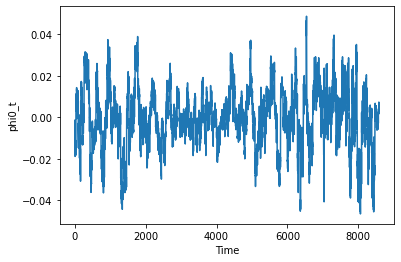

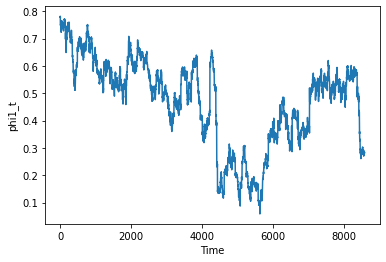

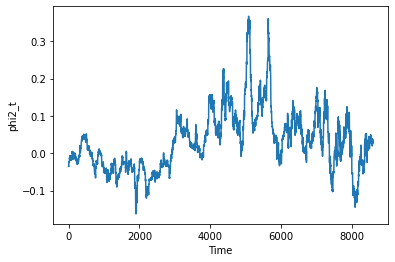

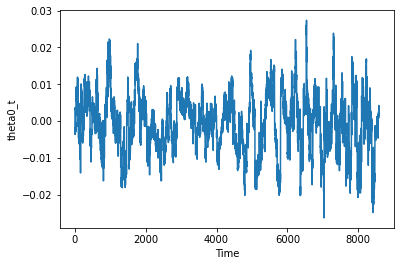

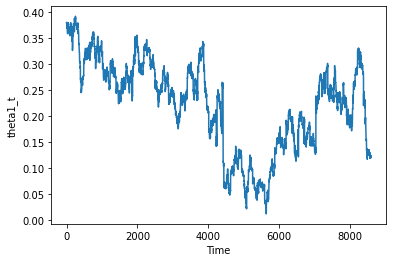

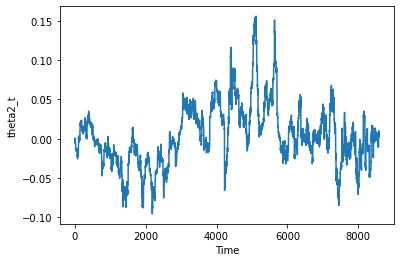

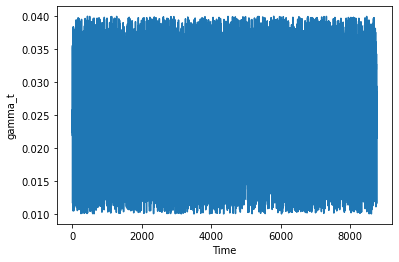

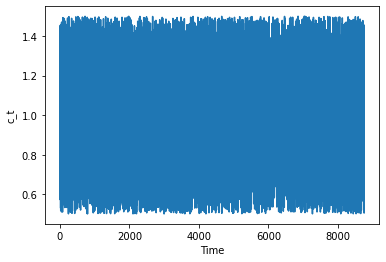

In [18]:
import matplotlib.pyplot as plt

# plot phi0_t
plt.plot(phi0_t)
plt.xlabel('Time')
plt.ylabel('phi0_t')
plt.show()

# plot phi1_t
plt.plot(phi1_t)
plt.xlabel('Time')
plt.ylabel('phi1_t')
plt.show()

# plot phi2_t
plt.plot(phi2_t)
plt.xlabel('Time')
plt.ylabel('phi2_t')
plt.show()

# plot theta0_t
plt.plot(theta0_t)
plt.xlabel('Time')
plt.ylabel('theta0_t')
plt.show()

# plot theta1_t
plt.plot(theta1_t)
plt.xlabel('Time')
plt.ylabel('theta1_t')
plt.show()

# plot theta2_t
plt.plot(theta2_t)
plt.xlabel('Time')
plt.ylabel('theta2_t')
plt.show()

# plot gamma_t
plt.plot(gamma_t)
plt.xlabel('Time')
plt.ylabel('gamma_t')
plt.show()

# plot c_t
plt.plot(c_t)
plt.xlabel('Time')
plt.ylabel('c_t')
plt.show()

In [ ]:
#x_window = x.iloc[i:j, :]
#y_hat_window = STR(x_window.values, phi0_window, phi1_window, phi2_window, theta0_window, theta1_window, theta2_window, gamma_window, c_window)


In [ ]:
#plt.plot(y_hat_window)
#plt.show()

In [20]:
y_hat = STR(x[window_size:].values, phi0_t, phi1_t, phi2_t, theta0_t, theta1_t, theta2_t, gamma_t[window_size:], c_t[window_size:])


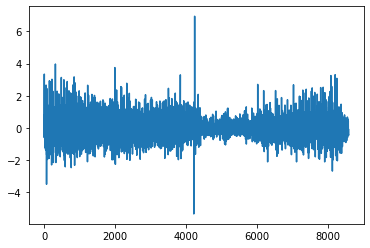

In [21]:
plt.plot(y_hat)
plt.show()

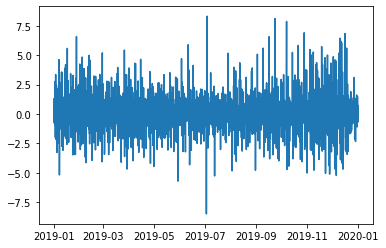

In [22]:
plt.plot(y)
plt.show()

In [23]:
SS_res = np.sum((y[window_size:] - y_hat)**2)
SS_tot = np.sum((y[window_size:] - np.mean(y[window_size:]))**2)
R_squared = 1 - SS_res / SS_tot
print(R_squared)

0.4227866665402913


In [24]:
n = len(y[window_size:])
p = 6
adj_R_squared = 1 - (1 - R_squared) * (n - 1) / (n - p - 1)
print(adj_R_squared )

0.4223832089446764


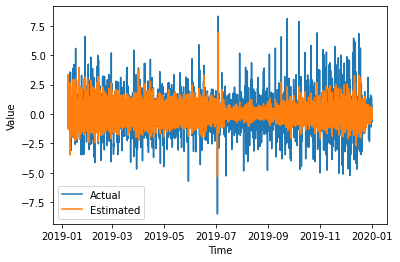

In [25]:
import matplotlib.pyplot as plt
import numpy as np



# Plot the two time series against each other
plt.plot(y[window_size:].index, y[window_size:], label='Actual')
plt.plot(y[window_size:].index,y_hat, label='Estimated')

# Add labels and a legend to the plot
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

# Display the plot
plt.show()

In [151]:
import numpy as np

#Calculate evaluation criteria

mse = np.mean((y[window_size:] - y_hat)**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y[window_size:] - y_hat))
r2 = 1 - np.sum((y[window_size:] - y_hat)**2) / np.sum((y[window_size:] - np.mean(y))**2)
u_stat = np.sqrt(np.mean((y[window_size:] - y_hat)**2) / np.mean(y[window_size:]**2))

#Print the results

print('MSE:', mse)
print('RMSE:', rmse)
print('MAE:', mae)
print('R^2:', r2)
print("Theil's U-statistic:", u_stat)

MSE: 0.6235675601262922
RMSE: 0.7896629408338043
MAE: 0.4967974811618808
R^2: 0.377619609580121
Theil's U-statistic: 0.7889108887700049


In [152]:
phi0_avg = np.mean(phi0_t)
phi1_avg = np.mean(phi1_t)
phi2_avg = np.mean(phi2_t)
theta0_avg = np.mean(theta0_t)
theta1_avg = np.mean(theta1_t)
theta2_avg = np.mean(theta2_t)
gamma_avg = np.mean(gamma_t)
c_avg = np.mean(c_t)

print(f"phi0_avg: {phi0_avg}")
print(f"phi1_avg: {phi1_avg}")
print(f"phi2_avg: {phi2_avg}")
print(f"theta0_avg: {theta0_avg}")
print(f"theta1_avg: {theta1_avg}")
print(f"theta2_avg: {theta2_avg}")
print(f"gamma_avg: {gamma_avg}")
print(f"c_avg: {c_avg}")

phi0_avg: 0.0006709477873523269
phi1_avg: 0.3565923982298188
phi2_avg: 0.06241444155397125
theta0_avg: 0.0008607010785487189
theta1_avg: 0.1748648167926495
theta2_avg: 0.029807984158555796
gamma_avg: 0.024964577978376805
c_avg: 1.0014595150271879
